# Outros Gráficos

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import path
import numpy as np
%matplotlib inline
pd.__version__

'0.24.2'

In [3]:
def parseInt(value):
    if value == True:
        return 1
    elif value == False:
        return 0
    else:
        return pd.np.nan

In [4]:
import scipy.stats as ss
from collections import Counter
import math 
from scipy import stats

def convert(data, to):
    converted = None
    if to == 'array':
        if isinstance(data, np.ndarray):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values
        elif isinstance(data, list):
            converted = np.array(data)
        elif isinstance(data, pd.DataFrame):
            converted = data.as_matrix()
    elif to == 'list':
        if isinstance(data, list):
            converted = data
        elif isinstance(data, pd.Series):
            converted = data.values.tolist()
        elif isinstance(data, np.ndarray):
            converted = data.tolist()
    elif to == 'dataframe':
        if isinstance(data, pd.DataFrame):
            converted = data
        elif isinstance(data, np.ndarray):
            converted = pd.DataFrame(data)
    else:
        raise ValueError("Unknown data conversion: {}".format(to))
    if converted is None:
        raise TypeError('cannot handle data conversion of type: {} to {}'.format(type(data),to))
    else:
        return converted
    
def conditional_entropy(x, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    :param x: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :param y: list / NumPy ndarray / Pandas Series
        A sequence of measurements
    :return: float
    """
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta

def associations(dataset, nominal_columns=None, mark_columns=False, theil_u=False, plot=True,
                          return_results = False, **kwargs):

    dataset = convert(dataset, 'dataframe')
    columns = dataset.columns
    if nominal_columns is None:
        nominal_columns = list()
    elif nominal_columns == 'all':
        nominal_columns = columns
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0,len(columns)):
        for j in range(i,len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                if columns[i] in nominal_columns:
                    if columns[j] in nominal_columns:
                        if theil_u:
                            corr[columns[j]][columns[i]] = theils_u(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = theils_u(dataset[columns[j]],dataset[columns[i]])
                        else:
                            cell = cramers_v(dataset[columns[i]],dataset[columns[j]])
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
                    else:
                        cell = correlation_ratio(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                else:
                    if columns[j] in nominal_columns:
                        cell = correlation_ratio(dataset[columns[j]], dataset[columns[i]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                    else:
                        cell, _ = ss.pearsonr(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    if mark_columns:
        marked_columns = ['{} (nom)'.format(col) if col in nominal_columns else '{} (con)'.format(col) for col in columns]
        corr.columns = marked_columns
        corr.index = marked_columns
    if plot:
        plt.figure(figsize=(20,20))#kwargs.get('figsize',None))
        sns.heatmap(corr, annot=kwargs.get('annot',True), fmt=kwargs.get('fmt','.2f'), cmap='coolwarm')
        plt.show()
    if return_results:
        return corr

# 1. Azure

In [5]:
dataframe = pd.read_excel('all_attributes.xlsx', usecols=range(0,29), sheet_name='azure')

In [6]:
#converte pra inteiro as colunas booleanas
bool_columns = list(filter(lambda x: x.startswith('A_' or 'E_' or 'V_'), dataframe.columns))
for col in bool_columns:
    dataframe[col] = dataframe[col].apply(parseInt)

In [7]:
dataframe.columns

Index(['FILENAME', 'IMAGE', 'GENDER', 'G_AZURE', 'A_GENDER_AZURE',
       'A_MALE_AZURE', 'E_MALE_AZURE', 'A_FEMALE_AZURE', 'E_FEMALE_AZURE',
       'MODA_AGE', 'AGE_MIN', 'AGE_MAX', 'AGE_AZURE', 'V_AGE_AZURE',
       'Attractive', 'Is this person famous?', 'Common?',
       'How much emotion is in this face?', 'Emotion?', 'Eyes direction?',
       'Face direction?', 'Facial hair?', 'Friendly', 'Makeup?',
       'Image quality', 'Race', 'Memorable',
       'At what speed do you think this expression is happening?',
       'How much teeth is showing?'],
      dtype='object')

## Gráfico de correlação completo

In [8]:
dataframe = dataframe.drop(['FILENAME', 'IMAGE', 'A_MALE_AZURE', 'E_MALE_AZURE', 
                            'A_FEMALE_AZURE', 'E_FEMALE_AZURE', 'AGE_MIN', 'AGE_MAX', 'Is this person famous?',
                            'At what speed do you think this expression is happening?'], axis = 1)

In [9]:
#g = sns.stripplot(data = dataframe, x = 'A_GENDER_AZURE', y='Race')
#sns.despine()
#g.figure.set_size_inches(14,10)
#plt.show()

## pairgrid

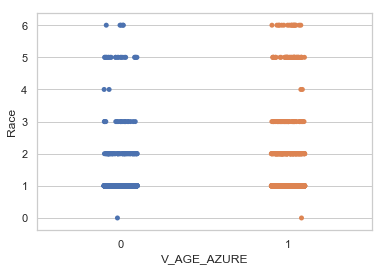

In [25]:
sns.set(style="whitegrid")

sns.stripplot(data = dataframe, x = 'V_AGE_AZURE', y = 'Race', jitter = 1)


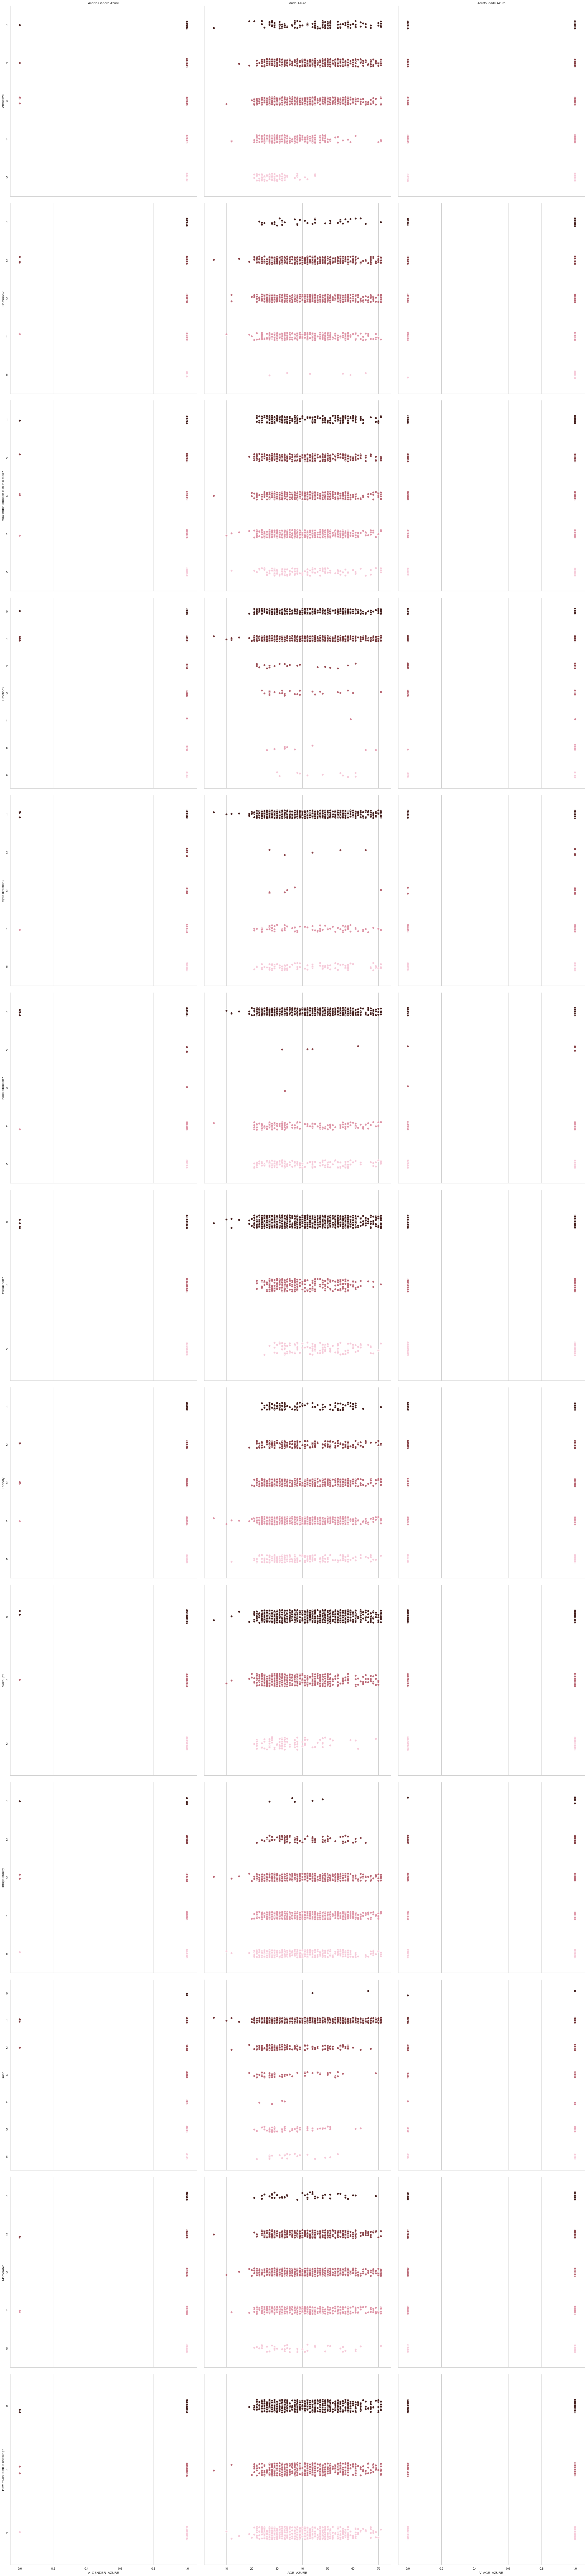

In [26]:
sns.set(style="whitegrid")

g = sns.PairGrid(dataframe,
                 x_vars = ['A_GENDER_AZURE', 'AGE_AZURE', 'V_AGE_AZURE'],
                 y_vars = dataframe.columns[6:], height = 10)

g.map(sns.stripplot, size=8, orient="h", palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")

titles = ['Acerto Gênero Azure', 'Idade Azure', 'Acerto Idade Azure']


for ax, title in zip(g.axes.flat, titles):
    ax.set(title = title)
    
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

g.savefig('pairgrid_azure_completo.pdf')

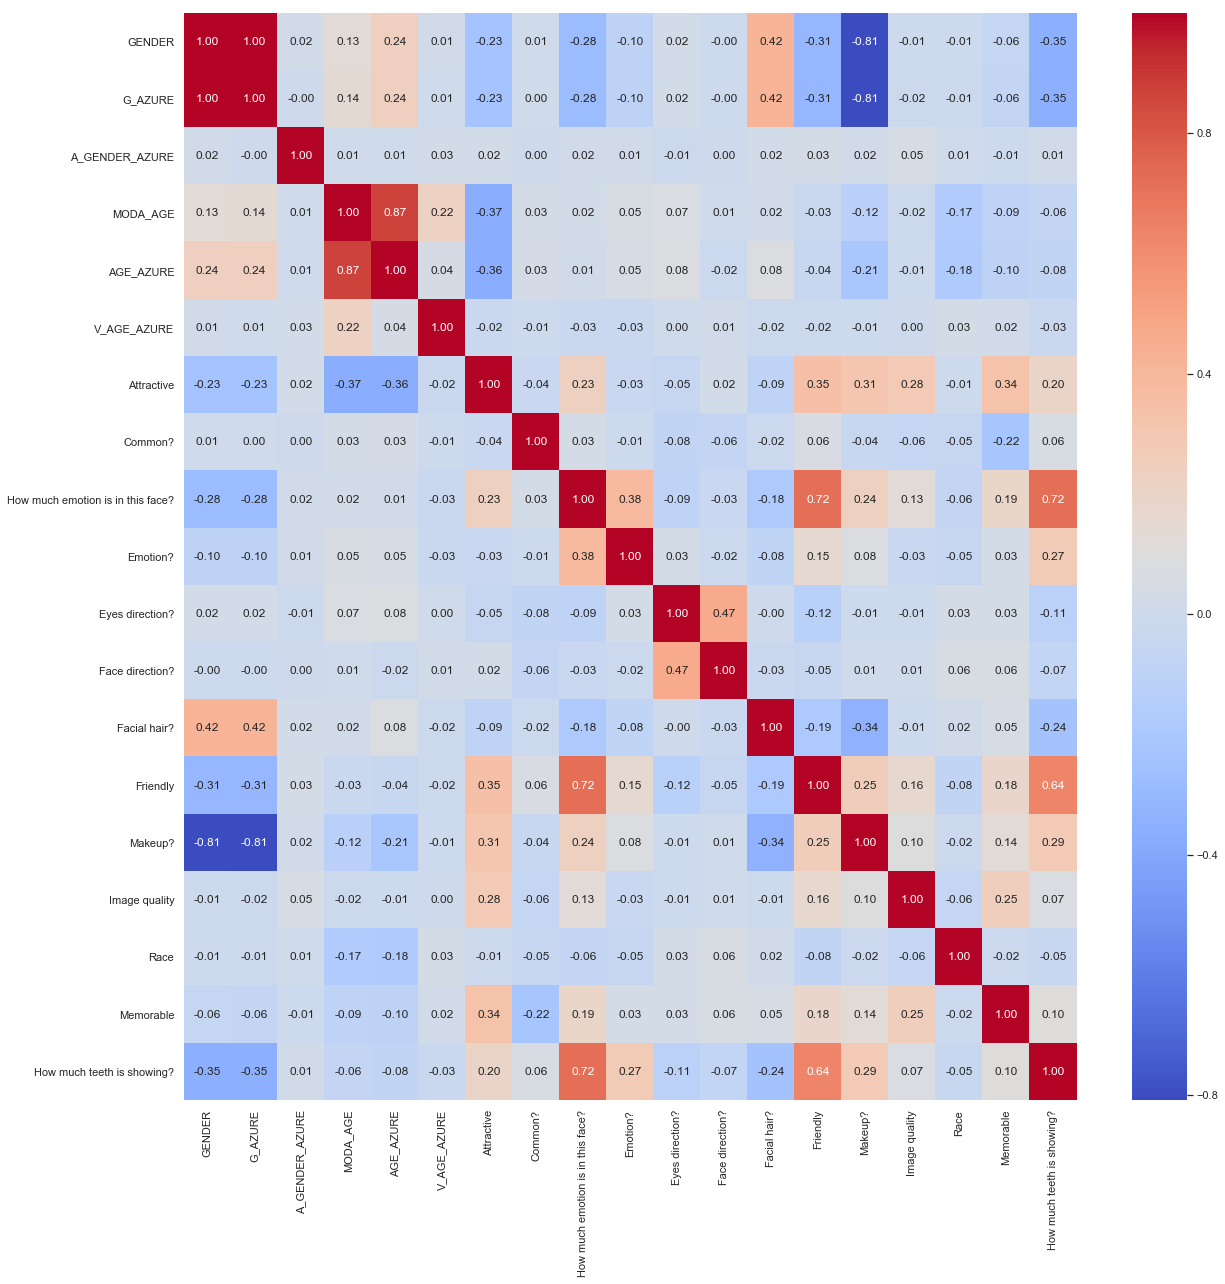

In [21]:
dataframe = dataframe.fillna(0)
results = associations(dataframe, return_results=True)
#graph = sns.pairplot(dataframe, height = 5)
#fig = graph.get_figure()
#fig.savefig("pairplot_completo_azure.pdf")

### filtro: apenas genero feminino

In [22]:
dataframe = pd.read_excel('all_attributes.xlsx', usecols=range(0,29), sheet_name='azure')

In [23]:
#converte pra inteiro as colunas booleanas
bool_columns = list(filter(lambda x: x.startswith('A_' or 'E_' or 'V_'), dataframe.columns))
for col in bool_columns:
    dataframe[col] = dataframe[col].apply(parseInt)

In [24]:
lista_fem = []

for line in dataframe.index:
    
    if dataframe['GENDER'][line] == 0:
        lista_fem.append(line)

dataframe = dataframe.loc[lista_fem, :]

In [25]:
dataframe = dataframe.drop(['FILENAME', 'IMAGE', 'GENDER', 'A_MALE_AZURE', 'E_MALE_AZURE', 
                            'A_FEMALE_AZURE', 'E_FEMALE_AZURE', 'AGE_MIN', 'AGE_MAX', 'Is this person famous?',
                            'At what speed do you think this expression is happening?'], axis = 1)

C:\Users\Lavinia\Anaconda3\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


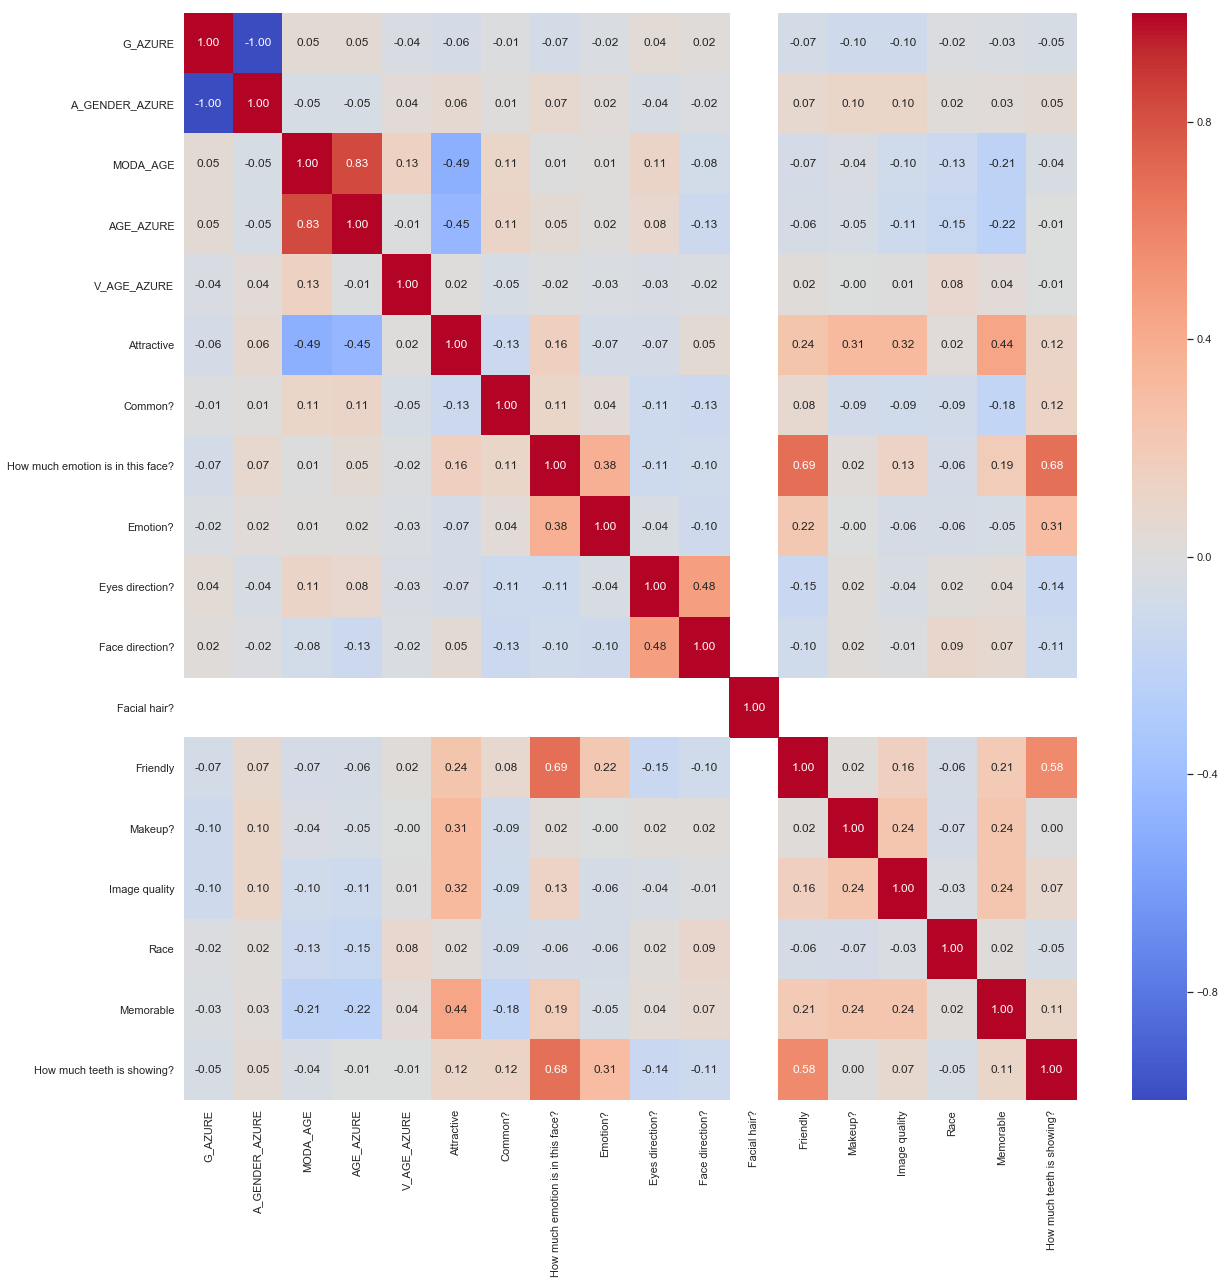

In [26]:
dataframe = dataframe.fillna(0)
results = associations(dataframe, return_results=True)

### filtro: apenas genero masculino

In [27]:
dataframe = pd.read_excel('all_attributes.xlsx', usecols=range(0,29), sheet_name='azure')

In [28]:
#converte pra inteiro as colunas booleanas
bool_columns = list(filter(lambda x: x.startswith('A_' or 'E_' or 'V_'), dataframe.columns))
for col in bool_columns:
    dataframe[col] = dataframe[col].apply(parseInt)

In [29]:
lista_male = []

for line in dataframe.index:
    
    if dataframe['GENDER'][line] == 1:
        lista_male.append(line)

dataframe = dataframe.loc[lista_male, :]

In [30]:
dataframe = dataframe.drop(['FILENAME', 'IMAGE', 'GENDER', 'A_MALE_AZURE', 'E_MALE_AZURE', 
                            'A_FEMALE_AZURE', 'E_FEMALE_AZURE', 'AGE_MIN', 'AGE_MAX', 'Is this person famous?',
                            'At what speed do you think this expression is happening?'], axis = 1)

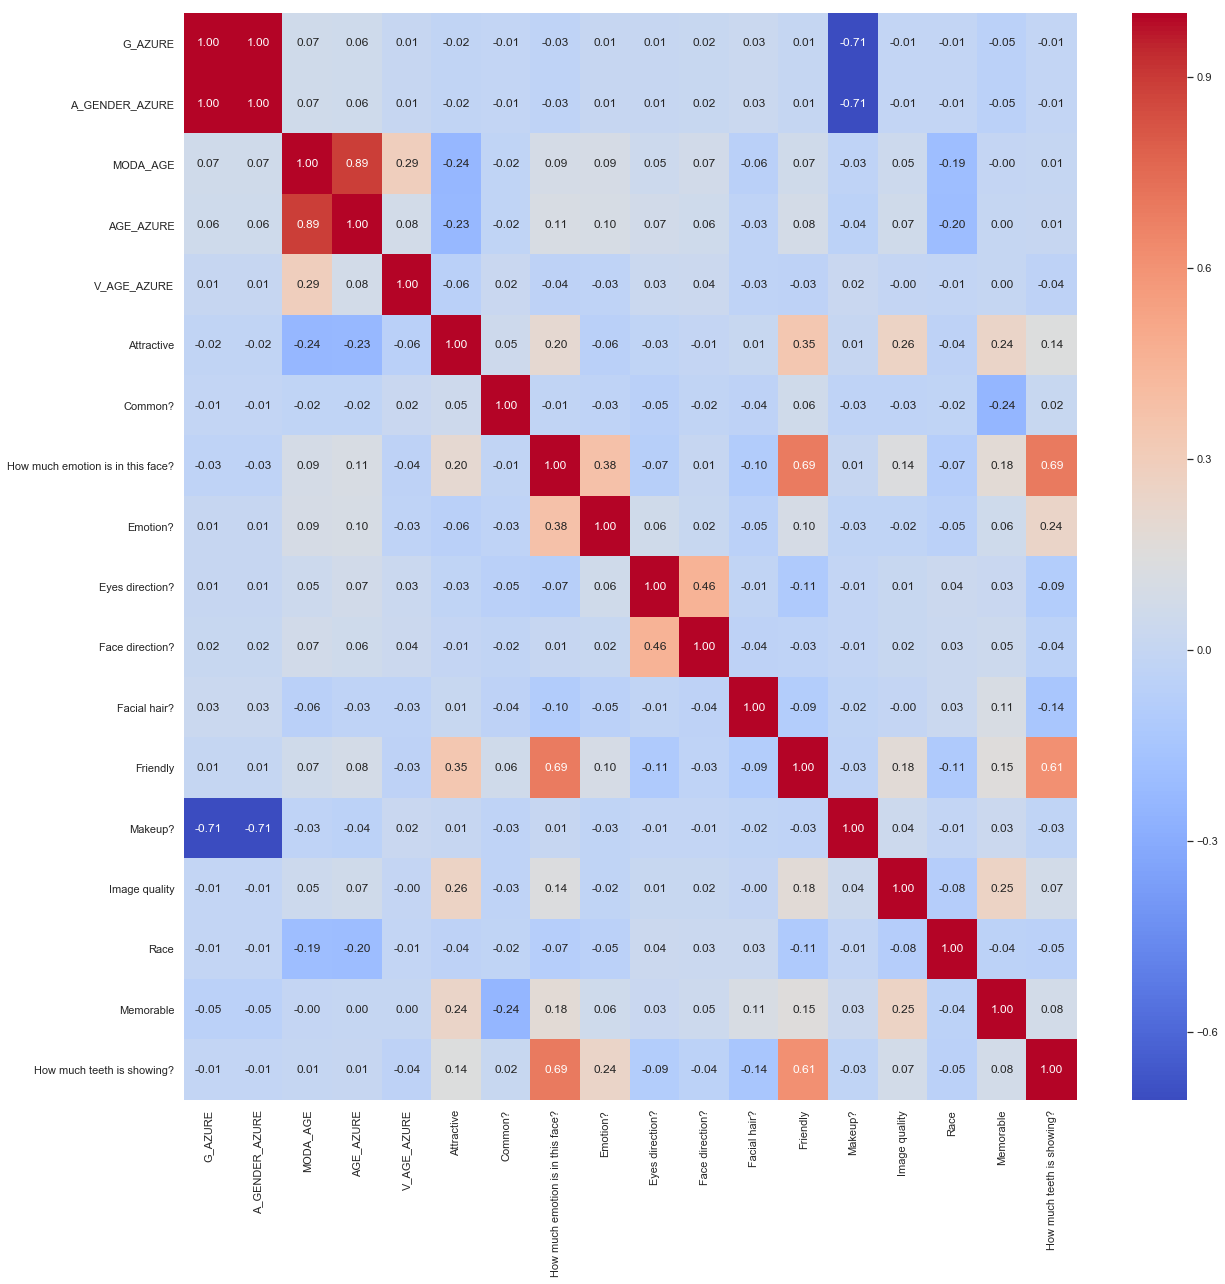

In [31]:
dataframe = dataframe.fillna(0)
results = associations(dataframe, return_results=True)

# 2. Rekognition

In [32]:
dataframe = pd.read_excel('all_attributes.xlsx', usecols=range(0,29), sheet_name='rekognition')

In [33]:
#converte pra inteiro as colunas booleanas
bool_columns = list(filter(lambda x: x.startswith('A_' or 'E_' or 'V_'), dataframe.columns))
for col in bool_columns:
    dataframe[col] = dataframe[col].apply(parseInt)

In [34]:
dataframe.columns

Index(['FILENAME', 'IMAGE', 'GENDER', 'G_AWS', 'A_GENDER_AWS', 'A_MALE_AWS',
       'E_MALE_AWS', 'A_FEMALE_AWS', 'E_FEMALE_AWS', 'MODA_AGE', 'AGE_MIN',
       'AGE_MAX', 'AGE_MIN_AWS', 'V_MIN_AWS', 'AGE_MAX_AWS', 'V_MAX_AWS',
       'Attractive', 'Is this person famous?', 'Common?',
       'How much emotion is in this face?', 'Emotion?', 'Eyes direction?',
       'Face direction?', 'Facial hair?', 'Friendly', 'Makeup?',
       'Image quality', 'Race', 'Memorable'],
      dtype='object')

## Gráfico de correlação completo

In [35]:
dataframe = dataframe.drop(['FILENAME', 'IMAGE', 'A_MALE_AWS',
       'E_MALE_AWS', 'A_FEMALE_AWS', 'E_FEMALE_AWS','AGE_MIN',
       'AGE_MAX', 'Is this person famous?'], axis = 1)

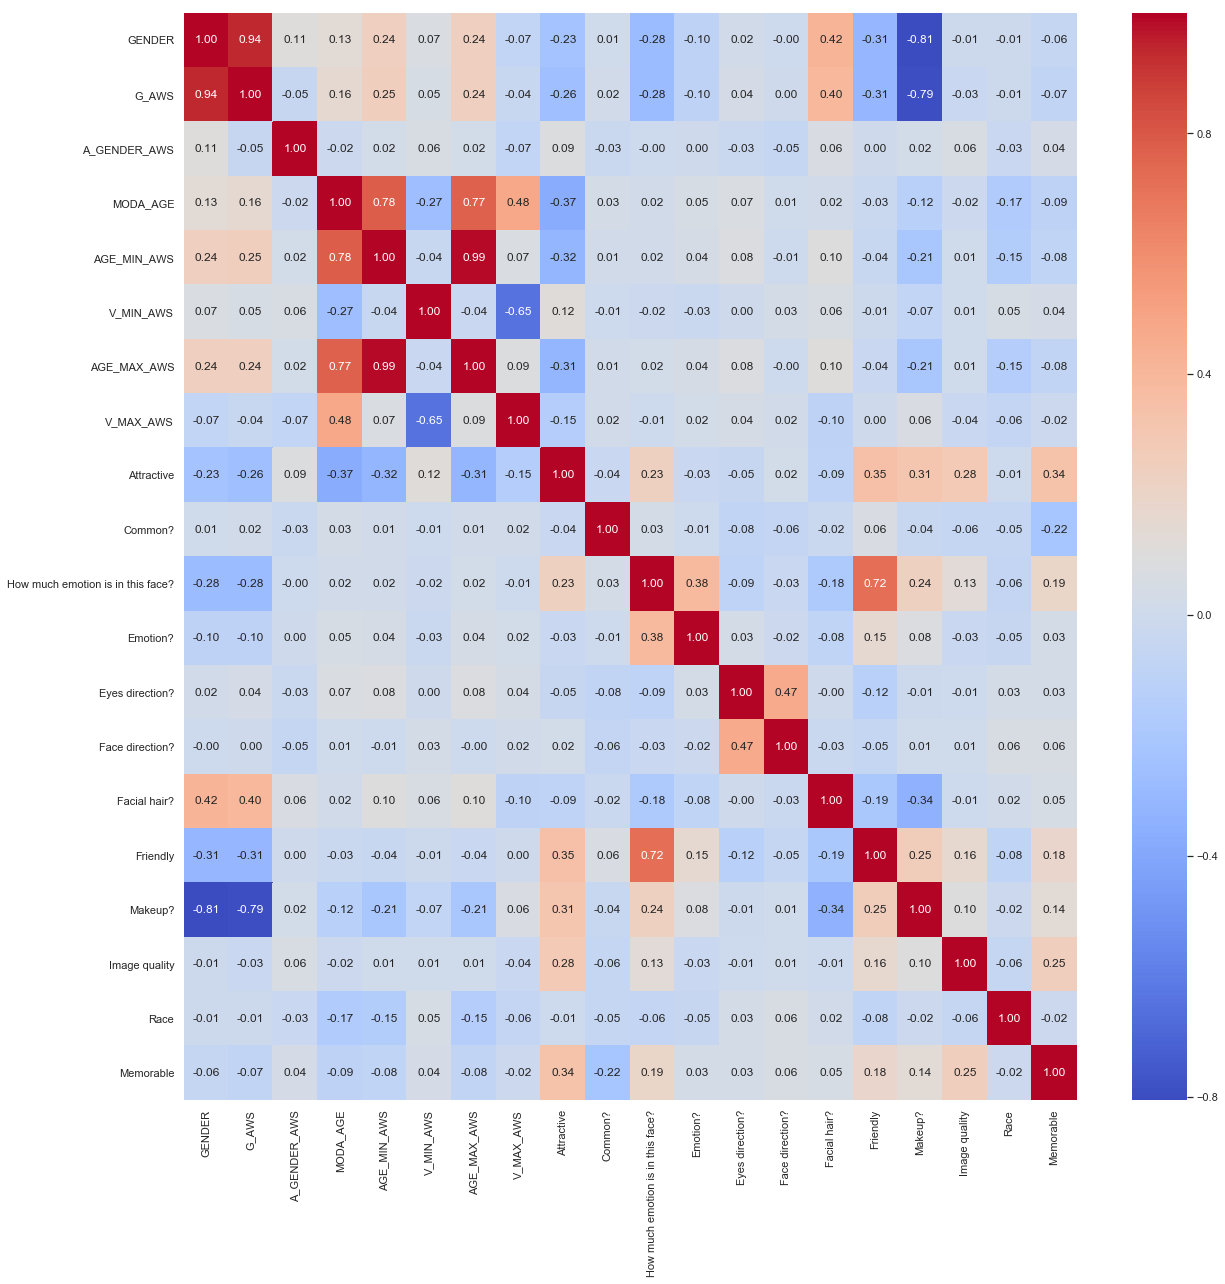

In [36]:
dataframe = dataframe.fillna(0)
results = associations(dataframe, return_results=True)

### filtro: apenas genero feminino

In [37]:
dataframe = pd.read_excel('all_attributes.xlsx', usecols=range(0,29), sheet_name='rekognition')

In [38]:
#converte pra inteiro as colunas booleanas
bool_columns = list(filter(lambda x: x.startswith('A_' or 'E_' or 'V_'), dataframe.columns))
for col in bool_columns:
    dataframe[col] = dataframe[col].apply(parseInt)

In [39]:
lista_fem = []

for line in dataframe.index:
    
    if dataframe['GENDER'][line] == 0:
        lista_fem.append(line)

dataframe = dataframe.loc[lista_fem, :]

In [40]:
dataframe = dataframe.drop(['FILENAME', 'IMAGE', 'GENDER', 'A_MALE_AWS', 'E_MALE_AWS', 
                             'A_FEMALE_AWS', 'E_FEMALE_AWS','AGE_MIN',
                             'AGE_MAX', 'Is this person famous?'], axis = 1)

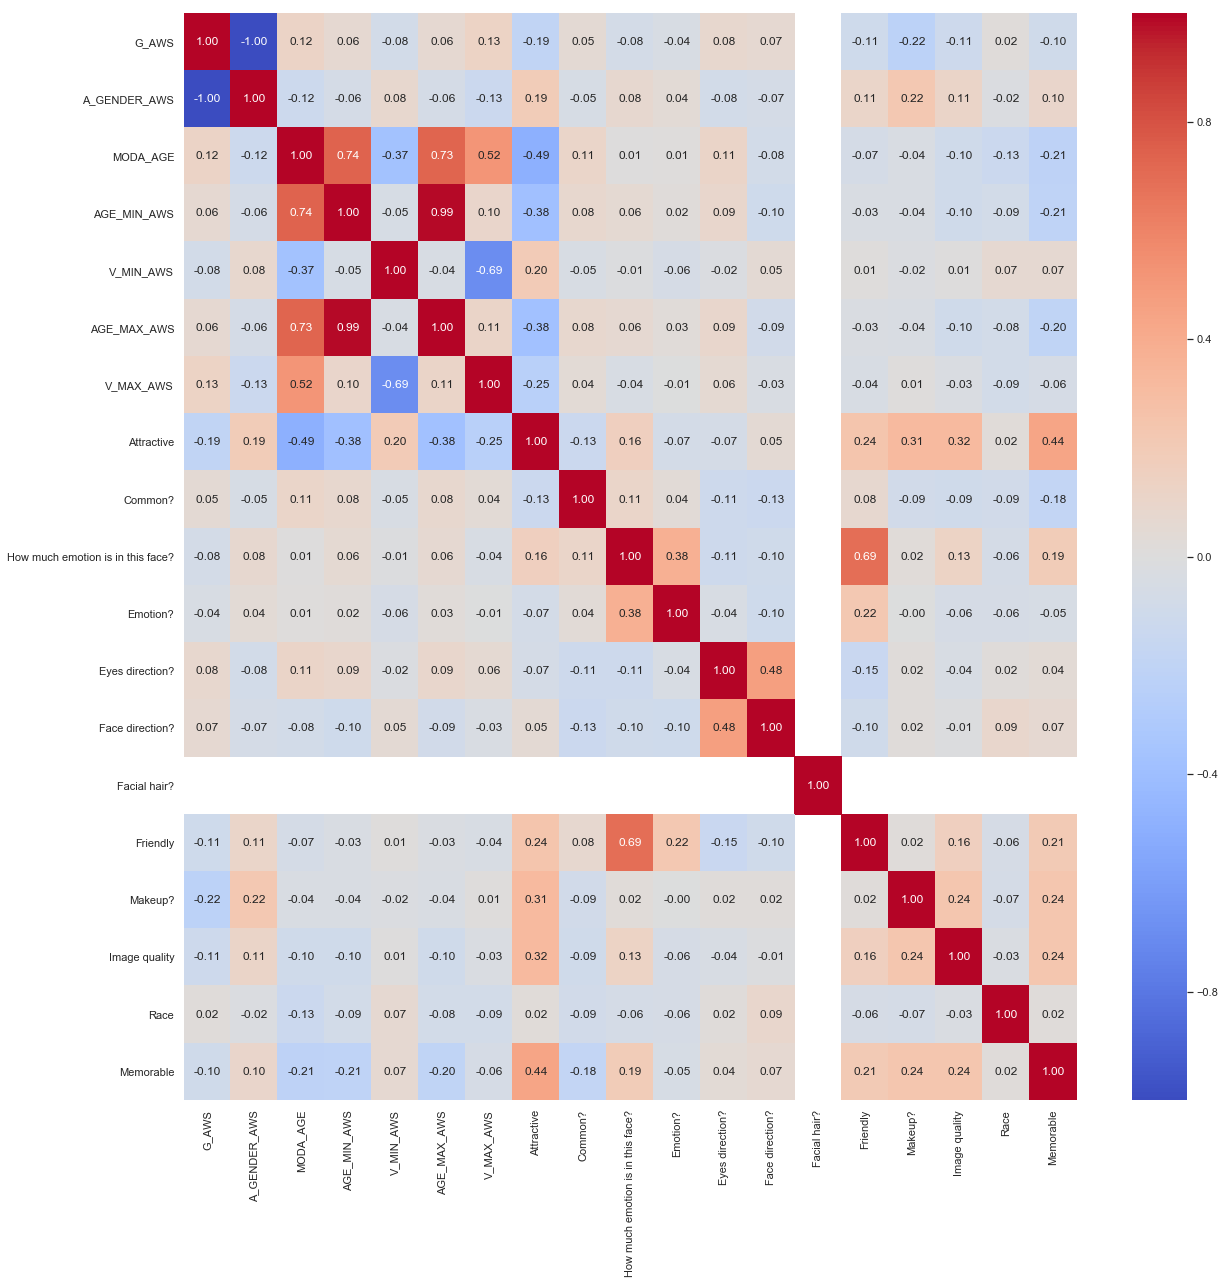

In [41]:
dataframe = dataframe.fillna(0)
results = associations(dataframe, return_results=True)

### filtro: apenas genero masculino

In [42]:
dataframe = pd.read_excel('all_attributes.xlsx', usecols=range(0,29), sheet_name='rekognition')

In [43]:
#converte pra inteiro as colunas booleanas
bool_columns = list(filter(lambda x: x.startswith('A_' or 'E_' or 'V_'), dataframe.columns))
for col in bool_columns:
    dataframe[col] = dataframe[col].apply(parseInt)

In [44]:
lista_male = []

for line in dataframe.index:
    
    if dataframe['GENDER'][line] == 1:
        lista_male.append(line)

dataframe = dataframe.loc[lista_male, :]

In [45]:
dataframe = dataframe.drop(['FILENAME', 'IMAGE', 'GENDER', 'A_MALE_AWS', 'E_MALE_AWS', 
                             'A_FEMALE_AWS', 'E_FEMALE_AWS','AGE_MIN',
                             'AGE_MAX', 'Is this person famous?'], axis = 1)

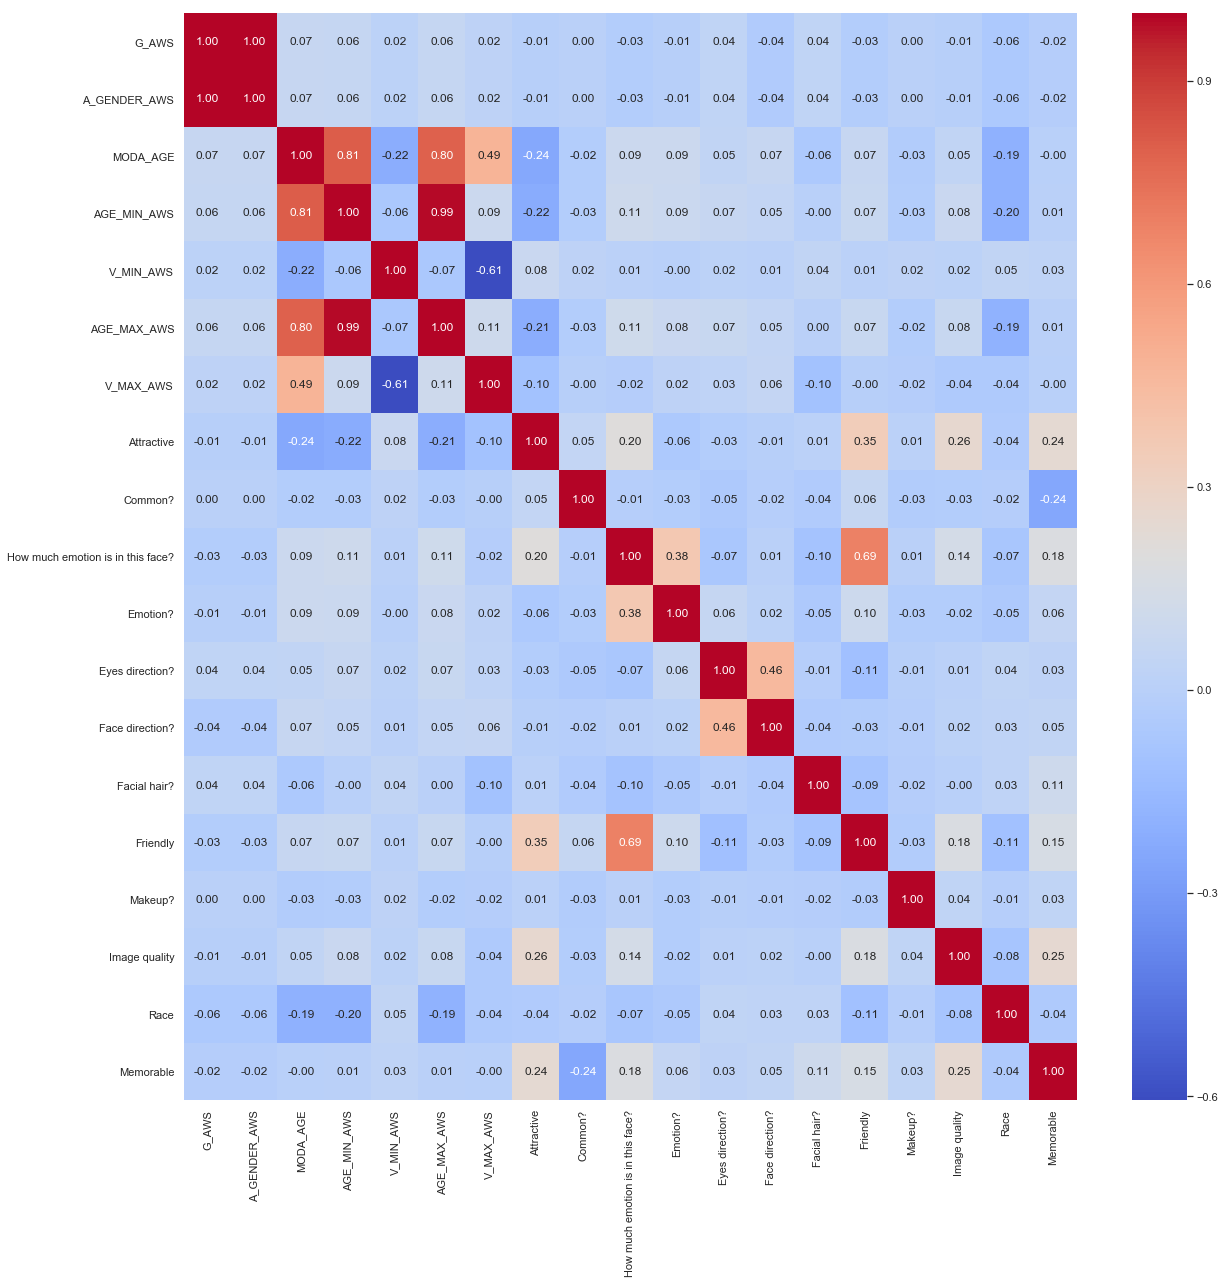

In [46]:
dataframe = dataframe.fillna(0)
results = associations(dataframe, return_results=True)

# 3. Watson

In [47]:
dataframe = pd.read_excel('all_attributes.xlsx', usecols=range(0,29), sheet_name='watson')

In [48]:
#converte pra inteiro as colunas booleanas
bool_columns = list(filter(lambda x: x.startswith('A_' or 'E_' or 'V_'), dataframe.columns))
for col in bool_columns:
    dataframe[col] = dataframe[col].apply(parseInt)

In [49]:
dataframe.columns

Index(['FILENAME', 'IMAGE', 'GENDER', 'G_WAT', 'A_GENDER_WAT', 'A_MALE_WAT',
       'E_MALE_WAT', 'A_FEMALE_WAT', 'E_FEMALE_WAT', 'MODA_AGE', 'AGE_MIN',
       'AGE_MAX', 'AGE_MIN_WATSON', 'V_MIN_WATSON', 'AGE_MAX_WATSON',
       'V_MAX_WATSON', 'Attractive', 'Is this person famous?', 'Common?',
       'How much emotion is in this face?', 'Emotion?', 'Eyes direction?',
       'Face direction?', 'Facial hair?', 'Friendly', 'Makeup?',
       'Image quality', 'Race', 'Memorable'],
      dtype='object')

## Gráfico de correlação completo

In [50]:
dataframe = dataframe.drop(['FILENAME', 'IMAGE', 'A_MALE_WAT',
       'E_MALE_WAT', 'A_FEMALE_WAT', 'E_FEMALE_WAT','AGE_MIN',
       'AGE_MAX', 'Is this person famous?'], axis = 1)

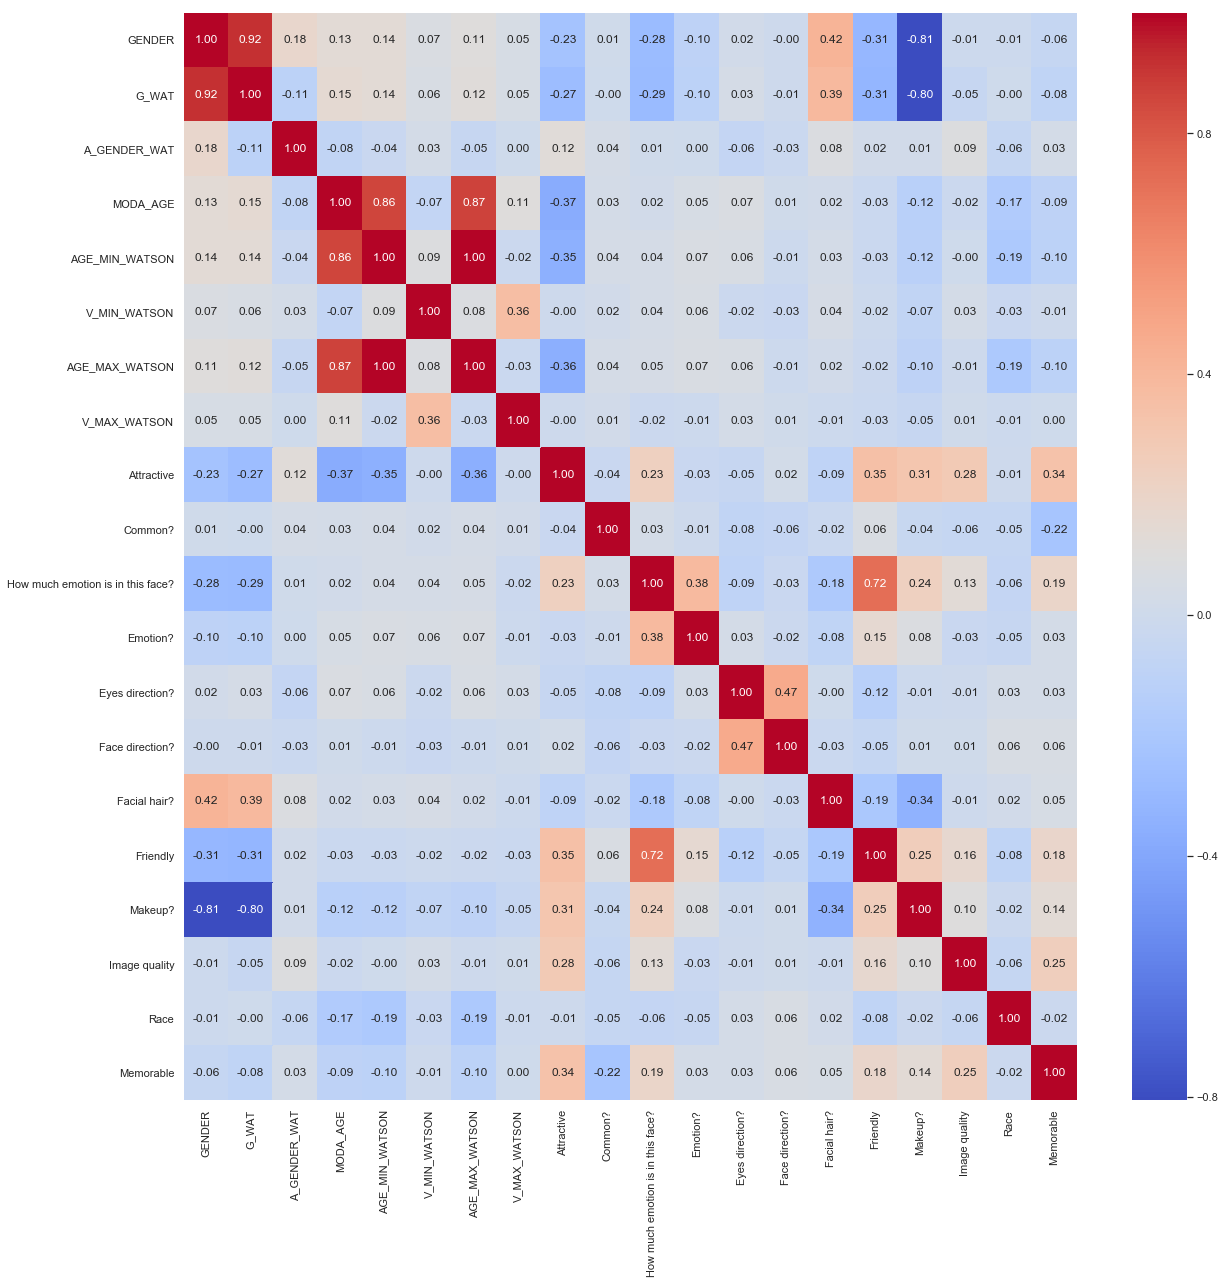

In [51]:
dataframe = dataframe.fillna(0)
results = associations(dataframe, return_results=True)

### filtro: apenas genero feminino

In [52]:
dataframe = pd.read_excel('all_attributes.xlsx', usecols=range(0,29), sheet_name='watson')

In [53]:
#converte pra inteiro as colunas booleanas
bool_columns = list(filter(lambda x: x.startswith('A_' or 'E_' or 'V_'), dataframe.columns))
for col in bool_columns:
    dataframe[col] = dataframe[col].apply(parseInt)

In [54]:
lista_fem = []

for line in dataframe.index:
    
    if dataframe['GENDER'][line] == 0:
        lista_fem.append(line)

dataframe = dataframe.loc[lista_fem, :]

In [55]:
dataframe = dataframe.drop(['FILENAME', 'IMAGE', 'GENDER', 'A_MALE_WAT', 'E_MALE_WAT', 'A_FEMALE_WAT', 'E_FEMALE_WAT',
                            'AGE_MIN', 'AGE_MAX', 'Is this person famous?'], axis = 1)

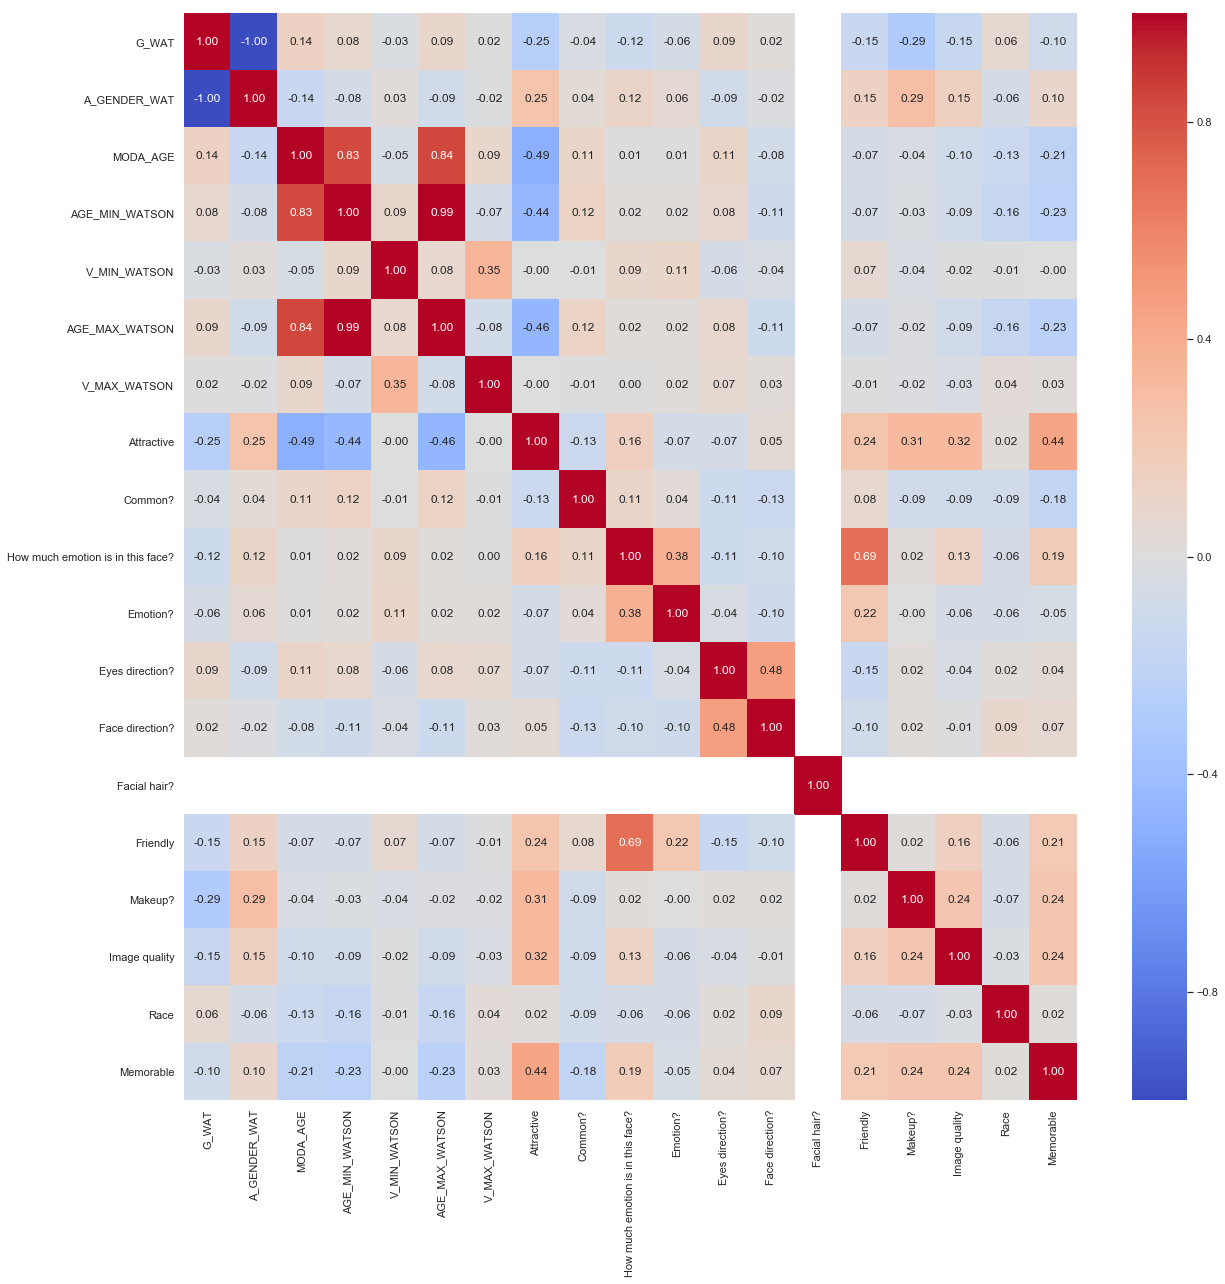

In [56]:
dataframe = dataframe.fillna(0)
results = associations(dataframe, return_results=True)

### filtro: apenas genero masculino

In [57]:
dataframe = pd.read_excel('all_attributes.xlsx', usecols=range(0,29), sheet_name='watson')

In [58]:
#converte pra inteiro as colunas booleanas
bool_columns = list(filter(lambda x: x.startswith('A_' or 'E_' or 'V_'), dataframe.columns))
for col in bool_columns:
    dataframe[col] = dataframe[col].apply(parseInt)

In [59]:
lista_male = []

for line in dataframe.index:
    
    if dataframe['GENDER'][line] == 1:
        lista_male.append(line)

dataframe = dataframe.loc[lista_male, :]

In [60]:
dataframe = dataframe.drop(['FILENAME', 'IMAGE', 'GENDER', 'A_MALE_WAT', 'E_MALE_WAT', 'A_FEMALE_WAT', 'E_FEMALE_WAT', 
                            'AGE_MIN', 'AGE_MAX', 'Is this person famous?'], axis = 1)

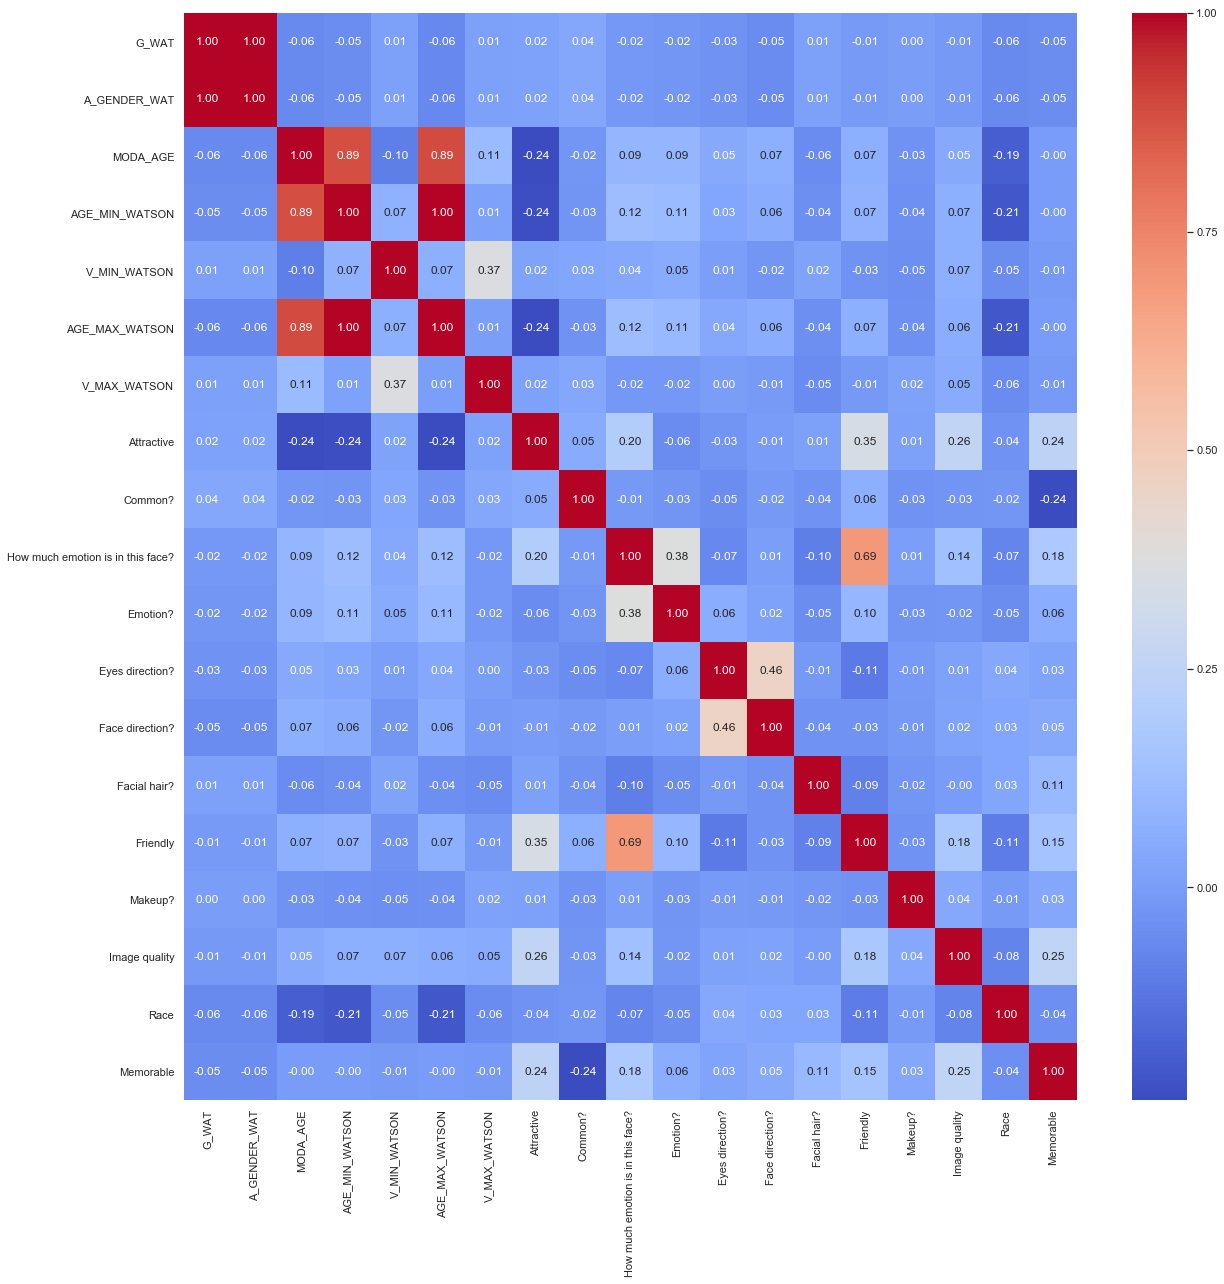

In [61]:
dataframe = dataframe.fillna(0)
results = associations(dataframe, return_results=True)